## Loading of modules and packages

Activate the Julia environment of the project.

In [1]:
using Pkg
Pkg.activate("..\\")

  Activating project at `C:\Users\Lenovo\Documents\GitHub\Tirocinio`


Load the necessary packages.

In [2]:
using ArchGDAL
using GeoStats
using Plots

Load the necessary modules.

In [6]:
include("..\\src\\Data Gathering\\GroundData.jl")

Main.GroundData

In [7]:
include("..\\src\\Data Gathering\\SatelliteData.jl")

Main.SatelliteData

In [8]:
include("..\\src\\Analysis\\DiluitionAttenuationFactor.jl")

Main.DiluitionAttenuationFactor

In [9]:
include("..\\src\\Analysis\\Lakes.jl")

Main.Lakes

In [10]:
include("..\\src\\Analysis\\Noises.jl")

Main.Noises

In [11]:
include("..\\src\\Analysis\\Plumes.jl")

Main.Plumes

In [12]:
include("..\\src\\Analysis\\Sediments.jl")

Main.Sediments


Aliasing of the modules to shorten the code.

In [13]:
# Modules
const agd = ArchGDAL

# Data gathering
const grdt = GroundData
const stdt = SatelliteData

# Data Analysis
const daf = DiluitionAttenuationFactor 
const lakes = Lakes
const noises = Noises
const plumes = Plumes
const sediments = Sediments

Main.Sediments

## Code testing 

#### Data Gathering testing

In [14]:
# DataFrame containing the gathered data, DataFrame containing the data that is not geolocalized. 
resmt, mresmt = grdt.getGroundData( :METEO, grdt.AA, grdt.FVG, grdt.L, grdt.T, grdt.V )

(110594×12 DataFrame
    Row │ uuid                               parameter                       u ⋯
        │ String                             String                          S ⋯
────────┼───────────────────────────────────────────────────────────────────────
      1 │ d45efdeb-8953-4cfe-bda8-ab510710…  Portata                         m ⋯
      2 │ d45efdeb-8953-4cfe-bda8-ab510710…  Livello idrometrico             c
      3 │ d45efdeb-8953-4cfe-bda8-ab510710…  Temperatura acqua               °
      4 │ d45efdeb-8953-4cfe-bda8-ab510710…  concentrazione solidi sospesi   m
      5 │ b4a8dc02-69ce-43bc-b38e-8f9dda53…  Portata                         m ⋯
      6 │ b4a8dc02-69ce-43bc-b38e-8f9dda53…  Livello idrometrico             c
      7 │ 024a71e2-592b-405a-b27d-a7c10150…  Temperatura dell´aria           °
      8 │ 024a71e2-592b-405a-b27d-a7c10150…  Direzione del vento             °
      9 │ 024a71e2-592b-405a-b27d-a7c10150…  Velocità del vento              m ⋯
     10 │ 024a71e2-

In [15]:
# Parameters measured by the stations
unique(resmt.parameter)

59-element Vector{String}:
 "Portata"
 "Livello idrometrico"
 "Temperatura acqua"
 "concentrazione solidi sospesi "
 "Temperatura dell´aria"
 "Direzione del vento"
 "Velocità del vento"
 "Velocitá raffica"
 "Umidità relativa"
 "Altezza neve al suolo"
 "Precipitazioni"
 "Radiazione globale "
 "Durata soleggiamento"
 ⋮
 "rh"
 "Temperatura aria a 2m"
 "Umidit\xe0 relativa a 2m"
 "Radiazione solare globale"
 "Velocit\xe0 vento a 5m"
 "Direzione vento a 5m"
 "Velocit\xe0 vento a 10m"
 "Direzione vento a 10m"
 "Pressione atmosferica ridotta a livello del mare"
 "Visibilit\xe0"
 "Velocit\xe0 vento a 2m"
 "Direzione vento a 2m"

In [16]:
# All relative humidity measurements
measurements = resmt[ resmt.parameter .== "Umidità relativa", : ]

# All the measurement's values
values = ( val = measurements.value, )

# All the coordinates of the measurements
coord = Tuple{Float64, Float64}[ (c[1], c[2]) for c in eachrow(measurements[:, [:longitude, :latitude]]) ]

86-element Vector{Tuple{Float64, Float64}}:
 (12.2096, 46.8417)
 (11.4604, 46.6156)
 (12.2005, 46.8561)
 (10.4878, 46.7767)
 (10.4979, 46.8064)
 (10.6144, 46.4938)
 (11.3184, 46.8401)
 (12.1221, 47.0362)
 (11.9036, 46.565)
 (11.825, 46.5314)
 (11.1146, 46.8289)
 (11.1016, 46.792)
 (12.2573, 46.6802)
 ⋮
 (11.2987, 46.8456)
 (10.774, 46.494)
 (11.8614, 46.9256)
 (12.1115, 46.6712)
 (11.2008, 46.5767)
 (11.3111, 46.4065)
 (11.3968, 46.3465)
 (11.7029, 46.8872)
 (11.1762, 46.8215)
 (11.3793, 46.9557)
 (11.6017, 46.4092)
 (12.3577, 46.6915)

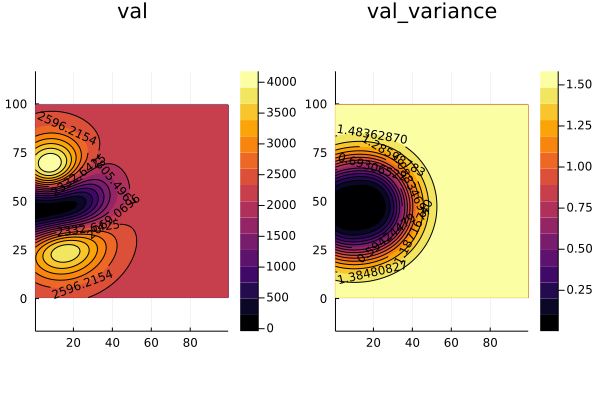

In [17]:
#= Based on:
    https://juliaearth.github.io/GeoStats.jl/stable/
=#

# Georeference data
D = georef(values, coord)

# Estimation domain
G = CartesianGrid(100, 100)

# Estimation problem
problem = EstimationProblem(D, G, :val)

# Solver from the list of solvers
solver = Kriging( :val => ( variogram = GaussianVariogram(range=35.0), ) )

# Solving problem
solution = solve(problem, solver)

# Solution plot
contourf(solution, clabels=true)

#### Data Analysis testing

##### Initial Setup

In [ ]:
# Digital Terrain Model, the main raster for the analysis, reppresents Veneto
dtm_file = "..\\resources\\Analysis data\\DTM_32.tiff"
dtm = agd.read(dtm_file)

Create a source point to test the analysis functions.

In [ ]:
# Coordinates of the source
# lat, lon = (726454.9302346368, 5.025993899219433e6)
lat, lon = (11.930065824163105, 45.425861311724816) # WGS84
# Path to the source shapefile
source_dir = "..\\resources\\Analysis data\\source_shapefile"
# Directory holding the `source` files
!isdir(source_dir) && mkdir(source_dir)
# Creation of a shapefile containing the point if not already existing
if "source.shp" ∉ readdir(source_dir)
    agd.create(
        source_dir*"\\source.shp",
        driver = agd.getdriver("ESRI Shapefile")
    ) do ds
        agd.createlayer(
            geom = agd.wkbPoint,
            spatialref = agd.importEPSG(4326)
        ) do layer
            agd.createfeature(layer) do feature
                agd.setgeom!(feature, agd.createpoint(lat, lon))
            end
            agd.copy(layer, dataset=ds)
        end
    end
end
source_file = source_dir*"\\source.shp"
source = agd.read(source_file)

Analysis functions execution.

Pollutants leaching.

In [ ]:
#=
contaminants: (vettore di String)
    nomi della sostanze da usare per estrarre i valori "c_henry", "koc_kd" dal database.
concentrations: (vettore di Float64)
    concentrazioni delle sostanze.
aquifer_depth: (Float64)
    profondità della falda.
acquifer_flow_direction: (Int64)
    angolo del flusso dell'aqua nella falda in gradi (credo?)
mean_rainfall: (Float64)
    pioggia media
texture: (String)
    credo sia la tipologia di terreno in cui filtrano gli inquinanti, da usare per estrarre i valori "tot_por", "c_water_avg", "effective_infiltration",
    "por_eff", "grain" dal database.
orthogonal_extension: (Float64)
    estensione ortogonale?
soil_density: (Float64)
    densità del suolo
source_thickness: (Float64)
    spessore fonte?
darcy_velocity: (Float64)
    velocità di Darcy?
mixed_zone_depth: (Float64)
    profondità zoma mista?
decay_coeff: (Float64)
    coefficiente di decadimento?
=#
daf.run_leach(source_file, contaminants, concentrations, aquifer_depth,
    acquifer_flow_direction, mean_rainfall, texture, 25, time,
    orthogonal_extension, soil_density, source_thickness, darcy_velocity,
    mixed_zone_depth, decay_coeff, algorithm,
    "..\\resources\\Analysis test data\\Analysis results\\daf.tiff")

Polutants dispersion in lakes.

In [ ]:
#=
wind_direction: (Int64)
    direzione del vento come angolo in gradi.
pollutant_mass: (Float64)
    massa dell'inquinante.
flow_mean_speed: (Float64)
    velocità del flusso.
hours: (Int64)
    durata dell'analisi in ore.
fickian_x: (Float64)
    ?
fickian_y: (Float64)
    ?
λk: (Float64)
    ?
=#
lakes.run_lake(source_file, wind_direction, pollutant_mass, flow_mean_speed, 25,
    hours, fickian_x, fickian_y, λk,
    "..\\resources\\Analysis test data\\Analysis results\\lake.tiff")

Noise pollution

In [ ]:
#=
"A" sostituisce il raster delle impedenze (nel codice uso una matrice contenente solo 0)
temperatura atmosferica in kelvin
umidità relativa (credo come percentuale in decimale)
intensità del suono
frequenza del suono
=#
noises.run_noise( dtm_file, "A", source_file, 293.15, 0.2, 110.0, 400.0 )

Airborne pollutants dispersion from a stack.

In [ ]:
#=
stability: (String)
    classe di stabilità da usare per ottenere     dal database.
wind_direction: (Int64)
    direzione del vento come angolo.
concentration: (Float64)
    concentrazione della sostanza.
wind_speed: (Float64)
    velocità del vento.
stack_height: (Float64)
    altezza del camino.
gas_speed: (Float64)
    velocità dei fumi?
stack_diameter: (Float64)
    diametro del camino.
smoke_temperature: (Float64)
    temperatura dei fumi.
temperature: (Float64)
    temperatura dell'ambiente.
=#
plumes.run_plume(dtm_file, source_file, stability, 25, wind_direction, concentration,
    wind_speed, stack_height, gas_speed, stack_diameter, smoke_temperature,
    temperature,
    "..\\resources\\Analysis test data\\Analysis results\\plumes.tiff")

Pollutants dispersion in flowing water.

In [ ]:
#=
mean_flow_speed: (Float64)
    velocità media della corrente.
mean_depth: (Float64)
    profondità media.
x_dispersion_coeff: (Float64)
    coefficiente di dispersione su x?
y_dispersion_coeff: (Float64)
    coefficiente di dispersione su y?
dredged_mass: (Float64)
    massa trasportata.
flow_direction: (Int64)
    direzione del flusso come angolo in gradi.
mean_sedimentation_velocity: (Float64)
    velocità di sedimentazione.
time: (Int64)
    tempo di inizio del modello.
time_intreval: (Int64)
    lunghezza di un'epoca.
current_oscillatory_amplitude: (Float64)
    ampiezza di oscillazione della corrente?
tide: (Int64)
    ciclo di marea in ore?.
=#
sediments.run_sediment(dtm_file, source_file, 25, mean_flow_speed, mean_depth,
    x_dispersion_coeff, y_dispersion_coeff, dredged_mass, flow_direction,
    mean_sedimentation_velocity, time, time_intreval,
    current_oscillatory_amplitude, tide,
    "..\\resources\\Analysis test data\\Analysis results\\sediments.tiff")